<a href="https://colab.research.google.com/github/Quirinimbus/Miscellaneous/blob/main/ML_UniBern_2022_Notebook_6_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6 - LSTM for time series data with Keras

In this exercise we want to build a simple Long Short Term Memory (LSTM) model to make forecasts for time series data. In particular, we will try to predict the Bitcoin price.

If you prefer an example from meteorology, you can take a look at the Keras example at https://keras.io/examples/timeseries/timeseries_weather_forecasting/. There, you will find some convenient "tricks" that we won't cover here, for example how to write data generators for time series models.

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

Here, we will use the data from the BW Sync&Share folder. The original dataset is available at https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory, from which we will use the market history of Bitcoin. There is also data on Ethereum available on BW Sync&Share, which you may use to build some more advanced models.

To work on Google Colab, we need to upload the relevant csv file(s). You can read more about how to do this on https://colab.research.google.com/notebooks/io.ipynb. 

Here, we will use one of the most simple options and upload the relevant file(s) from our local computer. Execute the next cell and click on "Browse", then select the `coin_Bitcoin.csv` file you downloaded from BW Sync&Share.

**Note:** This step may not work on Firefox. 

In [2]:
from google.colab import files

uploaded = files.upload()

Saving coin_Bitcoin.csv to coin_Bitcoin (2).csv


In [3]:
bitcoin_market_info = pd.read_csv("coin_Bitcoin.csv", index_col=0, parse_dates=['Date'])
bitcoin_market_info = bitcoin_market_info.set_index('Date')

bitcoin_market_info

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2013-04-29 23:59:59,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
2013-04-30 23:59:59,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2013-05-01 23:59:59,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
2013-05-02 23:59:59,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
2013-05-03 23:59:59,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,Bitcoin,BTC,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2021-07-03 23:59:59,Bitcoin,BTC,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2021-07-04 23:59:59,Bitcoin,BTC,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11


Let's look at the history of the closing price in USD, which we will try to predict.

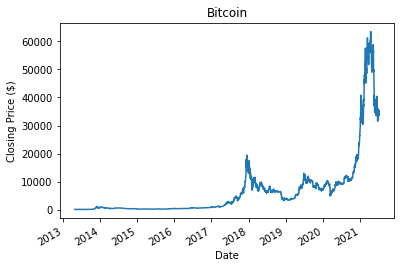

In [4]:
bitcoin_market_info['Close'].plot(title='Bitcoin',
                                  xlabel='Date',
                                  ylabel='Closing Price ($)')

We split the dataset into a training period (before January 1, 2020), and a test period (after January 1, 2020).

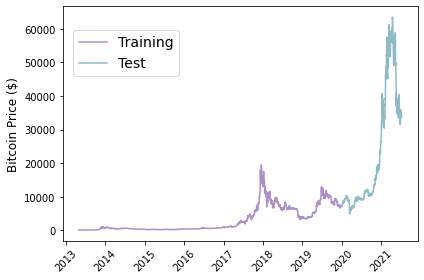

In [5]:
split_date = '2020-01-01'

plt.plot(bitcoin_market_info.index[bitcoin_market_info.index.values < np.datetime64(split_date)],
         bitcoin_market_info['Close'][bitcoin_market_info.index.values < np.datetime64(split_date)],
         color='#B08FC7', label='Training')
plt.plot(bitcoin_market_info.index[bitcoin_market_info.index.values >= np.datetime64(split_date)],
         bitcoin_market_info['Close'][bitcoin_market_info.index.values >= np.datetime64(split_date)],
         color='#8FBAC8', label='Test')

plt.ylabel('Bitcoin Price ($)',fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.03, 0.9), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [6]:
train_ds = bitcoin_market_info[bitcoin_market_info.index < split_date]
test_ds = bitcoin_market_info[bitcoin_market_info.index >= split_date]

## Persistence model

Before implementing a complicated machine learning model, we will use a very basic model as a first benchmark. To keep it as simple as possible, we will look at a model which simply sets tomorrow's price equal to today's price. This is called a persistence forecast.

Of course, there is a large variety of classical time series models available, some of which you may have encountered in your statistics lectures.

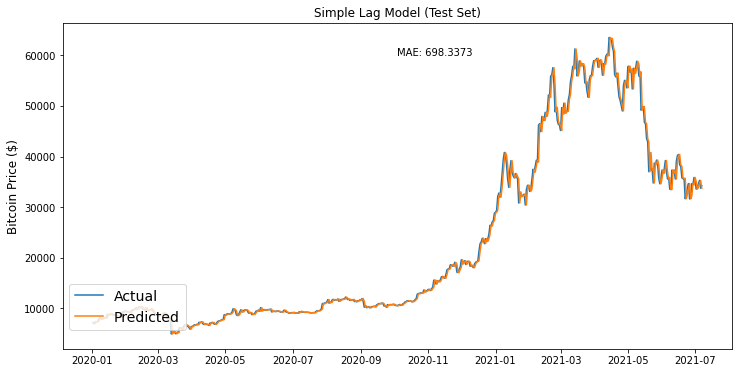

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(test_ds.index,
         test_ds['Close'],
         label='Actual')
plt.plot(test_ds.index[1:],
         test_ds['Close'].iloc[:-1],
         label='Predicted')

plt.ylabel('Bitcoin Price ($)',fontsize=12)
plt.legend(bbox_to_anchor=(0.01, 0.2), loc=2, borderaxespad=0., prop={'size': 14})
plt.title('Simple Lag Model (Test Set)')
plt.annotate('MAE: %.4f'%mean_absolute_error(test_ds['Close'].iloc[1:].values, test_ds['Close'].iloc[:-1].values),
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.5, 0.9), textcoords='axes fraction')

plt.show()

## Long Short Term Memory (LSTM)

Next, we will build an LSTM model to predict future prices. Note that generally, the use of LSTM-type models is questionable for autoregressive-type problems (https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/), but the main purpose of this exercise is to learn more about LSTMs, not to find the best possible model for Bitcoin prices.

First, we will modify our data to obtain (hopefully) better results. We only use the past history of the closing price, and remove all other columns.

A promising approach to obtain better results might be to use more columns or engineering additional columns.

In [8]:
LSTM_training_inputs = train_ds['Close']
LSTM_test_inputs = test_ds['Close']

In [9]:
LSTM_training_inputs.head()

Date
2013-04-29 23:59:59    144.539993
2013-04-30 23:59:59    139.000000
2013-05-01 23:59:59    116.989998
2013-05-02 23:59:59    105.209999
2013-05-03 23:59:59     97.750000
Name: Close, dtype: float64

In [10]:
ds_train = np.array(LSTM_training_inputs)
ds_test = np.array(LSTM_test_inputs)

In [11]:
ds_train

array([ 144.53999329,  139.        ,  116.98999786, ..., 7422.65258898,
       7292.99507783, 7193.59897843])

Since we saw that the Bitcoin price as varied a lot over time, we normalize the input data. To make our life easy, we use the `MinMaxScaler` from scikitlearn. We convert the original dataframe into a numpy array to simplify data handling a bit, in particular the reshaping required for the `MinMaxScaler`.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train = scaler.fit_transform(ds_train.reshape(-1,1))

In [14]:
dataset_train[:10]

array([[0.00391729],
       [0.00363215],
       [0.00249931],
       [0.001893  ],
       [0.00150904],
       [0.00226821],
       [0.00244372],
       [0.00225792],
       [0.00221674],
       [0.00232308]])

We can see that the values now are arranged on a scale from 0 to 1. We apply the same transformation to the test data. 

Note that we specifically use the `scaler` that was fit on the training data to avoid information from the test set "leaking" into the model training. 

In [15]:
ds_test = np.array(LSTM_test_inputs)
dataset_test = scaler.transform(ds_test.reshape(-1,1))
dataset_test[:10]

array([[0.36706751],
       [0.35601677],
       [0.37451565],
       [0.37790093],
       [0.37793494],
       [0.39635597],
       [0.41665932],
       [0.41234466],
       [0.40201003],
       [0.41680662]])

The LSTM model uses previous data to predict the next day's closing price. We must decide how many days it will have access to. Lets chose a "look-back" window of 25 time steps (= days) for now (other window lengths might lead to better results).

For model training, we create data frames where each consists of 25 consecutive days.

In [16]:
window_len = 25

In [17]:
LSTM_training_inputs = []
for i in range(len(dataset_train) - window_len):
    temp_set = dataset_train[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)

LSTM_test_inputs = []
for i in range(len(dataset_test) - window_len):
    temp_set = dataset_test[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set)

In [18]:
LSTM_training_inputs[0]

array([[0.00391729],
       [0.00363215],
       [0.00249931],
       [0.001893  ],
       [0.00150904],
       [0.00226821],
       [0.00244372],
       [0.00225792],
       [0.00221674],
       [0.00232308],
       [0.00227696],
       [0.00251012],
       [0.00240939],
       [0.00239688],
       [0.00255026],
       [0.00221674],
       [0.00235674],
       [0.00259041],
       [0.00280941],
       [0.00283427],
       [0.00275666],
       [0.00275717],
       [0.00280246],
       [0.0028544 ],
       [0.00299908]])

We transform the list into an array to make it easier to interpret for us (and the LSTM model later on).

In [19]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [20]:
LSTM_training_inputs.shape

(2413, 25, 1)

In [21]:
LSTM_test_inputs.shape

(528, 25, 1)

We will now use Keras functionalities to build an LSTM model. For illustrative purposes, we will consider yet another way to set up a Keras model.

The `build_model` function constructs an empty model, to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m, where n and m represent the number of timepoints/rows and columns, respectively). 
The function also includes more generic neural network features, like the activation function(s). 

Now, we just need to specify the parameters of the LSTM layer (i.e., the number of "units" to place in the LSTM layer). Note that the terminology is somewhat confusing here ("units" =  dimensionality of the hidden state of the LSTM cell, the h_t in the slides), see https://keras.io/api/layers/recurrent_layers/lstm/ and https://stats.stackexchange.com/questions/241985/understanding-lstm-units-vs-cells).

To read more on LSTMs and other RNN layers in Keras, see https://keras.io/guides/working_with_rnns/. 

In [33]:
def build_model(inputs, output_size, units, activ_func="linear", loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(units, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=False))
    model.add(Dense(output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [23]:
# We could also add multiple LSTM layers by setting return_sequences=True. 
# Note that this changes the shape of the model output and will require to adjust the predictions below.
# (you may try prediction = prediction[:,0,:])

#def build_model(inputs, output_size, units, activ_func="linear", dropout_rate=0.25, loss="mae", optimizer="adam"):
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True, dropout=dropout_rate))
#     # model.add(Dropout(dropout)) # --> that's not how you should use dropout in LSTMs!
#     model.add(LSTM(units=50, return_sequences=True, dropout=dropout_rate))
#     model.add(LSTM(units=50, dropout=dropout_rate))
#     model.add(Dense(units=100))
#     model.add(Activation(activ_func))
#     model.add(Dense(units=output_size))
#     model.add(Activation(activ_func))
#     model.compile(loss=loss, optimizer=optimizer)
#     return model

In [39]:
# initialise model architecture
model = build_model(LSTM_training_inputs, output_size=1, units = 100)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Next, we need to construct the target outputs corresponding to the training data. As before, we extract the relevant data, and normalize it using the `MinMaxScaler`.

In [41]:
LSTM_training_outputs = train_ds['Close'][window_len:].values
LSTM_training_outputs = np.array(LSTM_training_outputs)
LSTM_training_outputs = scaler.transform(LSTM_training_outputs.reshape(-1,1))
LSTM_training_outputs = LSTM_training_outputs.flatten()
LSTM_training_outputs.shape

(2413,)

We can now fit our model. Note that the `shuffle=True` argument only effects the order in which the training sequences are shown to the network, not the order of values within the sequences.

In [42]:
history = model.fit(LSTM_training_inputs, LSTM_training_outputs,
                    epochs=15, 
                    batch_size=1, 
                    verbose=1, 
                    shuffle=True)

Epoch 1/15
2413/2413 [==============================] - 26s 10ms/step - loss: 0.0142
Epoch 2/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0096
Epoch 3/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0084
Epoch 4/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0078
Epoch 5/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0077
Epoch 6/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0073
Epoch 7/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0072
Epoch 8/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0071
Epoch 9/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0070
Epoch 10/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0067
Epoch 11/15
2413/2413 [==============================] - 24s 10ms/step - loss: 0.0068
Epoch 12/15
2413/2413 [==============================] - 24s 10

With the fitted model, we can now make predictions on the test set.

In [43]:
prediction = model.predict(LSTM_test_inputs)
prediction.shape

(528, 1)

In [44]:
prediction[:10]

array([[0.43324414],
       [0.44497988],
       [0.46099162],
       [0.48427367],
       [0.4825578 ],
       [0.49296117],
       [0.48480028],
       [0.4871292 ],
       [0.48434818],
       [0.481762  ]], dtype=float32)

Before evaluating the predictions on the test data, we need to transform the data back to the original scale by inverting the transformation we applied to normalize the data. 

In [45]:
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [46]:
prediction[:10]

array([[8485.918],
       [8713.931],
       [9025.022],
       [9477.369],
       [9444.031],
       [9646.158],
       [9487.601],
       [9532.85 ],
       [9478.816],
       [9428.569]], dtype=float32)

Finally, let's plot the data and look at the results. Keep in mind that the simple persistence model lead to an MAE of below 1000.

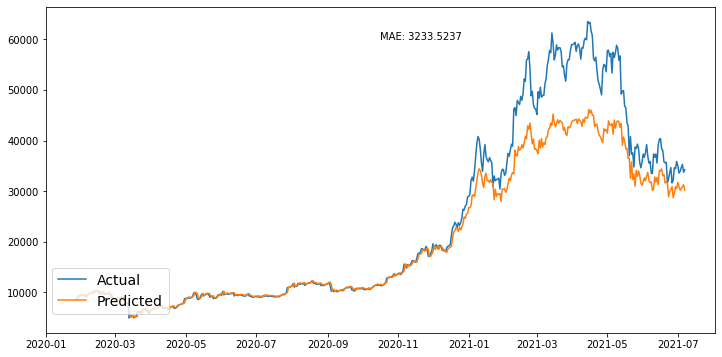

In [47]:
plt.figure(figsize=(12, 6))

plt.plot(test_ds.iloc[window_len:].index, test_ds.iloc[window_len:]['Close'],
         label='Actual')
plt.plot(test_ds.iloc[window_len:].index, prediction,
         label='Predicted')
plt.legend(bbox_to_anchor=(0.01, 0.2), loc=2, borderaxespad=0., prop={'size': 14})

plt.annotate('MAE: %.4f'%mean_absolute_error(test_ds['Close'].iloc[window_len:].values,prediction),
             xy=(0.75, 0.9),  xycoords='axes fraction',
             xytext=(0.5, 0.9), textcoords='axes fraction')

plt.show()

We can see that our LSTM model didn't do a particularly good job. The results will vary quite a bit depending on the randomness in the estimation procedure, but outperforming the simple persistence model is already very challenging. 

One particular problem seems to be to correctly capture the unprecedented magnitude of values in 2021. Perhaps the min-max normalization based on the training dataset was not the best choice here.

## Your turn

- As before, try to replicate the steps above by building a persistence benchmark and an LSTM model for the Bitcoin data.
- Try to improve the LSTM model by experimenting with tuning parameters, in particular adapting the model architecture and the window for estimation might change the results. You can also apply techniques learned in past notebooks such as learning rate decay or regularization. 
- You may also try different RNN cell types such as GRUs, you can read more here: https://keras.io/guides/working_with_rnns/

Further, you can extend the model(s) from above:
- Try to use multiple input features: We only used the history of the closing price, but there are more variables in the dataset and you may think about engineering new ones, for example some that take the volatility into account.
- Try to predict sequences: We focused on predicting the value of the next day only. In principle, it is possible to also predict sequences, see https://keras.io/examples/nlp/lstm_seq2seq/ as a starting point for further reading.
- You could also try to fit LSTM models for other cryptocurrencies, or multiple ones at once. Data for Ethereum is available on BW Sync&Share, data for even more different cryptocurrencies is available at the Kaggle link from above.
- The current dataset ends in July 2021. You can obtain a newer version from the Kaggle competition linkes above and investigate how the models worked in the more recent history.
- In principle, it would also be possible to re-train the model in a sliding window over time to adjust to recent changes in the data. However, this typically comes at a tremendous increas in computational costs.
- If you are generally interested in time series forecasting using deep learning models, you can also take a look at the GluonTS library (https://ts.gluon.ai/).